In [30]:
# Import 3rd party libraries
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

<strong>Importing Data</strong>

In [31]:
delay_df = pd.read_csv('Toronto-Subway-Delay-Jan-2014-Jun-2021.csv')
code_df = pd.read_csv('Toronto-Subway-Delay-Codes.csv')

In [32]:
delay_df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014/01/01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
1,2014/01/01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2,2014/01/01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
3,2014/01/01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
4,2014/01/01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


<h3>Importing Toronto Neighbourhoods shapefile</h3><br>
The shapefile for City of Toronto neighbourhood boundaries 'toronto_neighbourhoods.shp' is included in the assignment directory. 

In [33]:
neighbourhoods = gpd.read_file('Neighbourhoods.shp')
# View GeoDataFrame
neighbourhoods.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,FIELD_16,FIELD_17,geometry
0,26005521,Casa Loma (96),2480141,096,Casa Loma (96),096,None,None,None,None,17545105,None,3.678385e+06,8214.176485,None,None,1,"POLYGON ((-79.41469 43.67391, -79.41485 43.674..."
1,26005520,Annex (95),2480140,095,Annex (95),095,None,None,None,None,17545121,None,5.337192e+06,10513.883143,None,None,2,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
2,26005519,Caledonia-Fairbank (109),2480139,109,Caledonia-Fairbank (109),109,None,None,None,None,17545137,None,2.955857e+06,6849.911724,None,None,3,"POLYGON ((-79.46021 43.68156, -79.46044 43.681..."
3,26005444,Woodbine Corridor (64),2480064,064,Woodbine Corridor (64),064,None,None,None,None,17545153,None,3.052518e+06,7512.966773,None,None,4,"POLYGON ((-79.31485 43.66674, -79.31660 43.666..."
4,26005443,Lawrence Park South (103),2480063,103,Lawrence Park South (103),103,None,None,None,None,17545169,None,6.211341e+06,13530.370002,None,None,5,"POLYGON ((-79.41096 43.70408, -79.41165 43.703..."


In [34]:
# neighbourhoods contains a number of columns we don't need and with generic names
neighbourhoods = neighbourhoods[['FIELD_5','geometry']]
neighbourhoods.rename(columns = {'FIELD_5':'name'}, inplace = True)
neighbourhoods['name'] = neighbourhoods['name'].map(lambda s: s.rstrip('(1234567890)'))
# View GeoDataFrame
neighbourhoods.head()

,name,geometry
0,Casa Loma,"POLYGON ((-79.41469 43.67391, -79.41485 43.674..."
1,Annex,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
2,Caledonia-Fairbank,"POLYGON ((-79.46021 43.68156, -79.46044 43.681..."
3,Woodbine Corridor,"POLYGON ((-79.31485 43.66674, -79.31660 43.666..."
4,Lawrence Park South,"POLYGON ((-79.41096 43.70408, -79.41165 43.703..."


In [35]:
# View the first few entries in the "geometry" column
neighbourhoods.geometry.head()
# geometry is in polygon shape

0    POLYGON ((-79.41469 43.67391, -79.41485 43.674...
1    POLYGON ((-79.39414 43.66872, -79.39588 43.668...
2    POLYGON ((-79.46021 43.68156, -79.46044 43.681...
3    POLYGON ((-79.31485 43.66674, -79.31660 43.666...
4    POLYGON ((-79.41096 43.70408, -79.41165 43.703...
Name: geometry, dtype: geometry

<h3>Importing TTC Network lines shapefile</h3><br>
The city of Toronto publishes data about its TTC Network lines. Let's import 'TTC_SUBWAY_LINES_WGS84.shp' and take a look.

In [36]:
subway_lines = gpd.read_file('TTC_SUBWAY_LINES_WGS84.shp')

In [37]:
subway_lines.head()
# geometry is in LineString shape

,OBJECTID,ROUTE_NAME,RID,geometry
0,53420.0,LINE 1 (YONGE-UNIVERSITY),1,"LINESTRING (-79.52813 43.79677, -79.52689 43.7..."
1,53421.0,LINE 2 (BLOOR - DANFORTH),2,"LINESTRING (-79.53540 43.63781, -79.53386 43.6..."
2,53422.0,LINE 3 (SCARBOROUGH),3,"LINESTRING (-79.26332 43.73266, -79.26332 43.7..."
3,53423.0,LINE 4 (SHEPPARD),4,"LINESTRING (-79.41113 43.76145, -79.40981 43.7..."


In [38]:
subway_lines['ROUTE_NAME'].unique()
# There are four TTC Lines

array(['LINE 1 (YONGE-UNIVERSITY)', 'LINE 2 (BLOOR - DANFORTH)',
       'LINE 3 (SCARBOROUGH)', 'LINE 4 (SHEPPARD)'], dtype=object)

<h3>Importing TTC Stations shapefile</h3><br>
The city of Toronto publishes data about its TTC Station deatils. Let's import 'TTC Rapid Transit Stations Jan 2004_point.shp' and take a look.

In [11]:
subway_stations = gpd.read_file('TTC Rapid Transit Stations Jan 2004_point.shp')
subway_stations = subway_stations.explode().reset_index(drop=True)
subway_stations.head()
# geometry is in point shape

,STATION,STN_NO,geometry
0,KIPLING,1,POINT (618072.713 4832391.219)
1,ISLINGTON,2,POINT (619042.536 4833338.039)
2,ROYAL YORK,3,POINT (620125.579 4833672.088)
3,OLD MILL,4,POINT (621355.822 4833885.513)
4,JANE,5,POINT (622184.662 4833891.342)


In [40]:
print('Number of stations in TTC Network :',subway_stations.shape[0])

Number of stations in TTC Network : 70


Checking the crs of all three geodataframes

In [42]:
print(neighbourhoods.crs)
print(subway_lines.crs)
print(subway_stations.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}
{'init': 'epsg:26917', 'no_defs': True}


Only subway_stations has crs of epsg:26917 others have epsg:4326

Because we're working in a relatively small area (Toronto) and we'll be looking at areas and distances, we should transform to a 2D projection crs. Transforming neighbourhoods, and subway_lines to EPSG:26917.

In [13]:
neighbourhoods = neighbourhoods.to_crs(epsg=26917)
subway_lines = subway_lines.to_crs(epsg=26917)
subway_stations = subway_stations.to_crs(epsg=26917)

In [43]:
#crs check
subway_stations.crs

{'init': 'epsg:26917', 'no_defs': True}

<h3> GeoSpatialPlotting </h3> <br>
Plotting all three GeoDataFrame together again

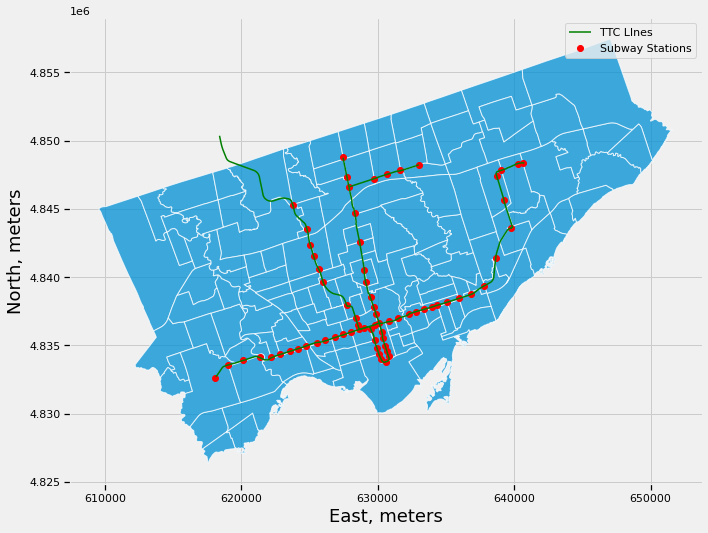

In [15]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
subway_lines.plot(ax=ax, color='green', label='TTC LInes');
subway_stations.plot(ax=ax, color='red', label='Subway Stations')
plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18)
plt.legend()
plt.show()

<h3>Neighbourhoods Analysis</h3>

Calculating the area in square kilometers of each neighbourhood and save this information as a new column named 'area' in the neighbourhoods GeoDataFrame.

In [16]:
neighbourhoods['area'] = neighbourhoods.geometry.area/10**6

# View GeoDataFrame
neighbourhoods.head()

,name,geometry,area
0,Casa Loma,"POLYGON ((627795.397 4836876.867, 627781.902 4...",1.922412
1,Annex,"POLYGON ((629463.304 4836332.300, 629324.313 4...",2.790299
2,Caledonia-Fairbank,"POLYGON ((624110.361 4837657.166, 624091.125 4...",1.544422
3,Woodbine Corridor,"POLYGON ((635860.212 4836239.139, 635719.852 4...",1.595665
4,Lawrence Park South,"POLYGON ((628032.302 4840233.689, 627977.197 4...",3.242396


Calculating the number of TTC stations in each neighbourhood and saving this information as a new column named 'stations' in the neighbourhoods GeoDataFrame. 

In [17]:
#Using the .within() GeoDataFrame method to check if a TTC station is in a neighbourhood
neighbourhoods['stations'] = neighbourhoods['geometry'].apply(lambda row: sum(subway_stations.geometry.within(row)))#, axis=1)
neighbourhoods = neighbourhoods.sort_values(by='stations', ascending=False)

#calculating a station density in units of stations per square km
neighbourhoods['station_density'] = round(neighbourhoods['stations']/neighbourhoods['area'])

# View GeoDataFrame
neighbourhoods.head(10)

,name,geometry,area,stations,station_density
41,Bay Street Corridor,"POLYGON ((630036.375 4834338.263, 630107.574 4...",1.809273,6,3.0
1,Annex,"POLYGON ((629463.304 4836332.300, 629324.313 4...",2.790299,6,2.0
15,Rosedale-Moore Park,"POLYGON ((631927.964 4837114.033, 631858.871 4...",4.668894,5,1.0
104,Dovercourt-Wallace Emerson-Junction,"POLYGON ((627517.108 4835724.334, 627480.745 4...",3.725831,4,1.0
135,Dorset Park,"POLYGON ((637264.757 4848044.206, 637331.396 4...",6.012148,3,0.0
120,High Park North,"POLYGON ((624787.820 4834865.849, 624678.256 4...",1.882268,3,2.0
118,Playter Estates-Danforth,"POLYGON ((631927.964 4837114.033, 631921.500 4...",0.887588,3,3.0
65,Danforth,"POLYGON ((635114.351 4838071.354, 635023.894 4...",1.119682,3,3.0
69,Yorkdale-Glen Park,"POLYGON ((625714.291 4840359.316, 625680.263 4...",6.038310,3,0.0
68,University,"POLYGON ((628394.442 4834951.967, 628330.470 4...",1.405221,2,1.0


<h3>Interactive Maps</h3>

In [18]:
# Assigning neighbourhood geography for plotting
plot_geography = neighbourhoods.to_crs(epsg=4326)[['name', 'geometry']]
plot_geography = plot_geography.set_index('name')
plot_geography.head()

,geometry
name,
Bay Street Corridor,"POLYGON ((-79.38752 43.65067, -79.38663 43.650..."
Annex,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
Rosedale-Moore Park,"POLYGON ((-79.36339 43.67532, -79.36425 43.675..."
Dovercourt-Wallace Emerson-Junction,"POLYGON ((-79.41842 43.66358, -79.41887 43.663..."
Dorset Park,"POLYGON ((-79.29443 43.77273, -79.29359 43.772..."


In [19]:
# station density data
plot_data = neighbourhoods[['name', 'station_density']]
plot_data.head()

,name,station_density
41,Bay Street Corridor,3.0
1,Annex,2.0
15,Rosedale-Moore Park,1.0
104,Dovercourt-Wallace Emerson-Junction,1.0
135,Dorset Park,0.0


<strong>To understand how access to the Toronto TTC network varies by neighbourhood, we'll create a choropleth map.</strong>

In [46]:
from folium import Choropleth
# Create a base map
map_6 = folium.Map(location=[43.6426, -79.3871], 
                 tiles='cartodbpositron',
                 zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           columns=['name', 'station_density'],
           data=plot_data, 
           key_on='feature.id', 
           fill_color='YlOrRd', 
           legend_name='Bikeshare Station Density (stations / km**2)'
          ).add_to(map_6)

# Display the map
map_6

<strong>To get interactive access to TTC stations location we plot a Marker plot using Folium</strong>

In [21]:
from folium import Marker

# Create a map of Toronto
map_1 = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron', 
                   zoom_start=10)

# Add points to the map
for idx, row in subway_stations.to_crs(epsg=4326).iterrows():
    Marker([row.geometry.y, row.geometry.x],popup=row['STATION']).add_to(map_1)

# Display map
map_1